<a href="https://colab.research.google.com/github/dinarasaurae/pyad-2024/blob/lr4/%D0%A5%D0%B8%D1%81%D0%B0%D0%BC%D0%B5%D1%82%D0%B4%D0%B8%D0%BD%D0%BE%D0%B2%D0%B0_%D0%94%D0%B8%D0%BD%D0%B0%D1%80%D0%B0_K3341_%22PY%D0%90%D0%94_%D0%9B%D0%A04_Text_Processing_%26_LLM_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [2]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 121MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [3]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [4]:
df.shape

(20502, 9)

Немного погрузимся в данные.

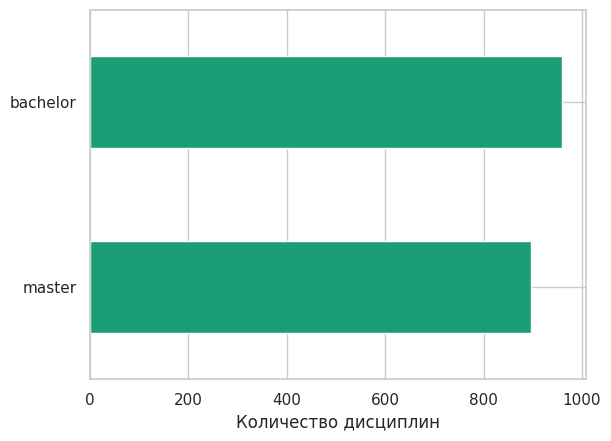

In [5]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

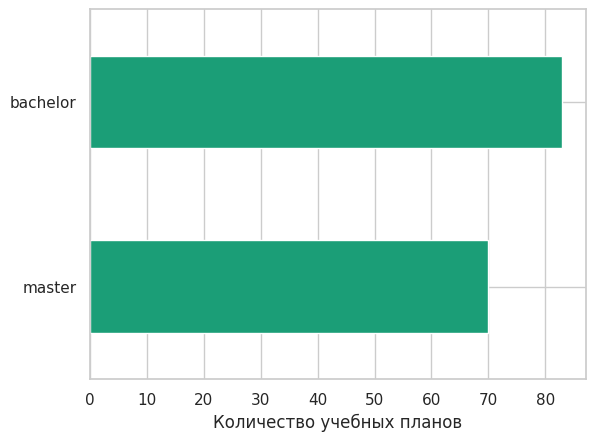

In [6]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

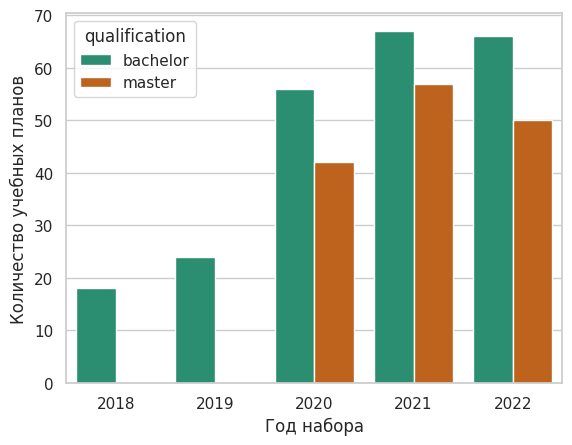

In [7]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

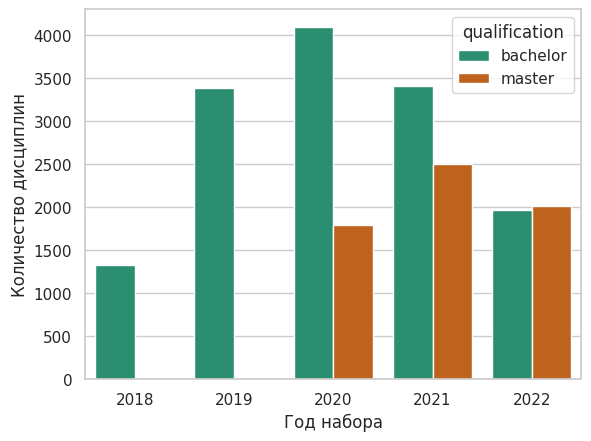

In [8]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [9]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem # для лемматизации
from gensim.utils import simple_preprocess


nltk.download('stopwords')
nltk.download('punkt')


m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [10]:
stop_words = set(stopwords.words('russian'))
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = " ".join(m.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = " ".join(simple_preprocess(text))

    return text

In [11]:
df['contents'] = df['contents'].apply(preprocess_text)

In [12]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,инновационный маркетинг корпоративный финансы ...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,математический модель сигнал помеха канал связ...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,особенность организация массовый мероприятие п...


Проведите предобработку для столбца `description`.

In [13]:
df['description'] = df['description'].apply(preprocess_text)

In [14]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,цель курс предоставлять возможность магистрант...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,инновационный маркетинг корпоративный финансы ...
2457,3002,Теория электрической связи,программа составлять соответствие требование о...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,математический модель сигнал помеха канал связ...
1077,2736,Организация массовых мероприятий,данный дисциплина учить планировать мероприяти...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,особенность организация массовый мероприятие п...


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [15]:
from gensim.models import Word2Vec
import gensim

In [16]:
tokenized_contents = df['contents'].apply(lambda x: x.split()).tolist()
tokenized_descriptions = df['description'].apply(lambda x: x.split()).tolist()

In [17]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово

w2v_model = Word2Vec(tokenized_contents + tokenized_descriptions, min_count=1, vector_size=300, workers=2, window=10)

In [18]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [19]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [20]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([ 0.39943734, -1.6235167 , -3.5667613 , -2.097988  ,  2.9381635 ,
       -2.8365798 , -1.5873169 ,  2.3288093 , -0.14577949,  0.8113566 ,
        0.26321545, -2.5113168 ,  1.3085538 , -1.7175428 , -0.45865116,
        0.9923497 , -1.4265022 ,  0.30268806,  0.03266471, -2.3653204 ,
        1.1060779 , -0.5131675 , -0.52059984, -3.3295844 , -1.6428475 ,
        2.178437  , -1.1837127 ,  0.7748792 ,  0.5144286 , -3.1675339 ,
        1.8729725 , -0.300287  ,  1.3184477 ,  4.152727  ,  1.6733673 ,
        2.2254567 ,  2.1244323 , -1.4593153 , -0.38418275, -2.1556206 ,
        1.1702492 , -1.5477848 ,  1.3464552 ,  0.7998346 , -2.9607816 ,
       -2.4960518 ,  2.3253894 ,  0.25081345,  1.0319217 , -2.3069603 ,
       -1.5765219 ,  5.703074  , -0.33693793,  3.8299975 , -0.15718734,
        1.0634955 , -3.6331425 ,  0.99284667,  0.20831135, -0.7467574 ,
        0.7568342 , -3.269968  ,  0.718118  ,  0.7717803 , -2.9897919 ,
        0.18436666, -2.1359124 , -4.5291486 ,  2.8562863 ,  1.54

In [21]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('бутстраппинг', 0.5867137312889099),
 ('дикторский', 0.544532299041748),
 ('аномалия', 0.541284441947937),
 ('подкрепление', 0.5143821239471436),
 ('автоэнкодер', 0.509989857673645),
 ('состязательный', 0.5002918839454651),
 ('учитель', 0.49504828453063965),
 ('crispdm', 0.4915491044521332),
 ('ия', 0.4880297780036926),
 ('сигмоидальный', 0.48336103558540344)]

In [22]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('статистика', 0.4603157341480255),
 ('данный', 0.440653532743454),
 ('пграмм', 0.43141818046569824),
 ('дихотомический', 0.4291999340057373),
 ('запрос', 0.4241849482059479),
 ('метафизика', 0.42116764187812805),
 ('compatibility', 0.41992834210395813),
 ('pe', 0.41955137252807617),
 ('количественный', 0.41742387413978577),
 ('высушивание', 0.4152243435382843)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

Вектором текста должно являться среднее всех векторов слов текста.

In [23]:
import numpy as np
def embed(tokens, w2v_model):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [24]:
df['vector_contents'] = df['contents'].apply(lambda x: embed(x.split(), w2v_model))
df['vector_description'] = df['description'].apply(lambda x: embed(x.split(), w2v_model))

In [25]:
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,vector_contents,vector_description
16112,17498,Создание технологического бизнеса,цель курс предоставлять возможность магистрант...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,инновационный маркетинг корпоративный финансы ...,"[0.014073358, -0.22862017, -0.08470086, 0.8055...","[-0.76724476, -0.68356276, -0.4372608, 0.44187..."
2457,3002,Теория электрической связи,программа составлять соответствие требование о...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,математический модель сигнал помеха канал связ...,"[0.28969476, 0.49469346, 0.39943787, -0.693944...","[0.15528038, -0.65855694, -0.2769101, -0.05094..."
1077,2736,Организация массовых мероприятий,данный дисциплина учить планировать мероприяти...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,особенность организация массовый мероприятие п...,"[-0.21595079, -0.08045659, -0.8768153, 0.68379...","[-0.308934, -0.1481336, -0.16462876, 0.6137792..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    return cs([vec1], [vec2])[0][0] if np.any(vec1) and np.any(vec2) else 0.0

In [27]:
# посчитаем косинусное сходство между содержанием и описанием
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["vector_contents"], x["vector_description"]), axis=1)
df["desc_cont_sim"]

,desc_cont_sim
0,0.836290
1,0.836290
2,0.836290
3,0.836290
4,0.836290
...,...
20497,0.728773
20498,0.791421
20499,0.638853
20500,0.812400


Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

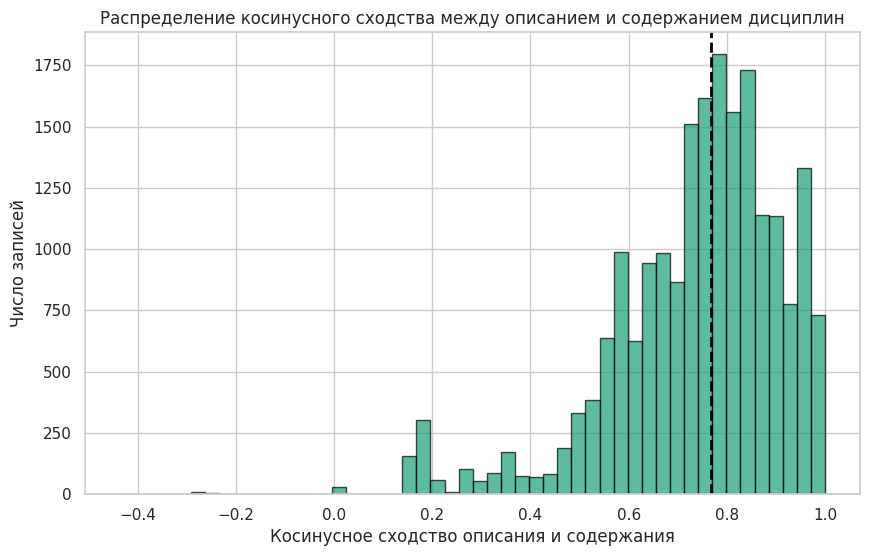

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(df["desc_cont_sim"], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(df["desc_cont_sim"].median(), color='black', linestyle='dashed', linewidth=2)
plt.xlabel("Косинусное сходство описания и содержания")
plt.ylabel("Число записей")
plt.title("Распределение косинусного сходства между описанием и содержанием дисциплин")
plt.show()

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [29]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/431k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

In [30]:
from tqdm.auto import tqdm

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [31]:
df['bert_contents'] = df['contents'].apply(lambda x: ' '.join(x.split()))
df['bert_description'] = df['description'].apply(lambda x: ' '.join(x.split()))

# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,vector_contents,vector_description,desc_cont_sim,bert_contents,bert_description
16112,17498,Создание технологического бизнеса,цель курс предоставлять возможность магистрант...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,инновационный маркетинг корпоративный финансы ...,"[0.014073358, -0.22862017, -0.08470086, 0.8055...","[-0.76724476, -0.68356276, -0.4372608, 0.44187...",0.579133,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...
2457,3002,Теория электрической связи,программа составлять соответствие требование о...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,математический модель сигнал помеха канал связ...,"[0.28969476, 0.49469346, 0.39943787, -0.693944...","[0.15528038, -0.65855694, -0.2769101, -0.05094...",0.499807,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...
1077,2736,Организация массовых мероприятий,данный дисциплина учить планировать мероприяти...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,особенность организация массовый мероприятие п...,"[-0.21595079, -0.08045659, -0.8768153, 0.68379...","[-0.308934, -0.1481336, -0.16462876, 0.6137792...",0.707782,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [32]:
from tqdm.auto import tqdm
tqdm.pandas()

unique_texts = pd.concat([df['bert_contents'], df['bert_description']]).unique()
unique_embeddings = {text: bert_model.encode(text) for text in tqdm(unique_texts, desc="Encoding texts")}

df['bert_vector_contents'] = df['bert_contents'].progress_apply(lambda x: unique_embeddings[x])
df['bert_vector_description'] = df['bert_description'].progress_apply(lambda x: unique_embeddings[x])

Encoding texts:   0%|          | 0/4607 [00:00<?, ?it/s]

  0%|          | 0/20502 [00:00<?, ?it/s]

  0%|          | 0/20502 [00:00<?, ?it/s]

Теперь присоедините полученную таблицу в исходный датафрейм.

In [33]:
df['bert_vector_contents'] = df['bert_vector_contents'].apply(lambda x: np.array(x))
df['bert_vector_description'] = df['bert_vector_description'].apply(lambda x: np.array(x))

# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 16)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,vector_contents,vector_description,desc_cont_sim,bert_contents,bert_description,bert_vector_contents,bert_vector_description
16112,17498,Создание технологического бизнеса,цель курс предоставлять возможность магистрант...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,инновационный маркетинг корпоративный финансы ...,"[0.014073358, -0.22862017, -0.08470086, 0.8055...","[-0.76724476, -0.68356276, -0.4372608, 0.44187...",0.579133,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...,"[-0.023032192, -0.023153134, 0.015452264, -0.0...","[0.01472445, -0.036152482, 0.040057003, 0.0234..."
2457,3002,Теория электрической связи,программа составлять соответствие требование о...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,математический модель сигнал помеха канал связ...,"[0.28969476, 0.49469346, 0.39943787, -0.693944...","[0.15528038, -0.65855694, -0.2769101, -0.05094...",0.499807,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...,"[-0.014655914, 0.013688283, 0.06277199, -0.010...","[0.036311354, -0.011928535, 0.014583108, -0.00..."
1077,2736,Организация массовых мероприятий,данный дисциплина учить планировать мероприяти...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,особенность организация массовый мероприятие п...,"[-0.21595079, -0.08045659, -0.8768153, 0.68379...","[-0.308934, -0.1481336, -0.16462876, 0.6137792...",0.707782,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...,"[0.020301338, 0.00046995067, 0.005992853, -0.0...","[0.031968344, -0.012318762, -0.0020125012, 0.0..."


In [34]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df['bert_vector_contents'][0].shape

(312,)

In [35]:
df['bert_vector_description'][0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [36]:
# Вычисление косинусного сходства между содержанием и описанием Tiny BERT
df["bert_desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["bert_vector_contents"], x["bert_vector_description"]), axis=1)

In [37]:
df["bert_desc_cont_sim"].describe()

,bert_desc_cont_sim
count,20502.000000
mean,0.875669
std,0.047119
min,0.616774
25%,0.850760
50%,0.882104
75%,0.907671
max,1.000000


Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

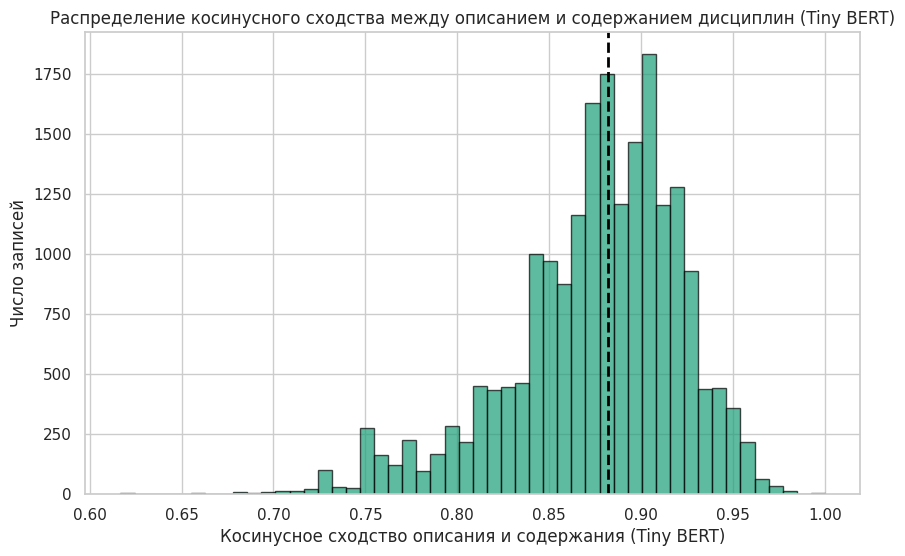

In [38]:
# Построение гистограммы распределения сходств Tiny BERT
plt.figure(figsize=(10, 6))
plt.hist(df["bert_desc_cont_sim"], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(df["bert_desc_cont_sim"].median(), color='black', linestyle='dashed', linewidth=2)
plt.xlabel("Косинусное сходство описания и содержания (Tiny BERT)")
plt.ylabel("Число записей")
plt.title("Распределение косинусного сходства между описанием и содержанием дисциплин (Tiny BERT)")
plt.show()

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

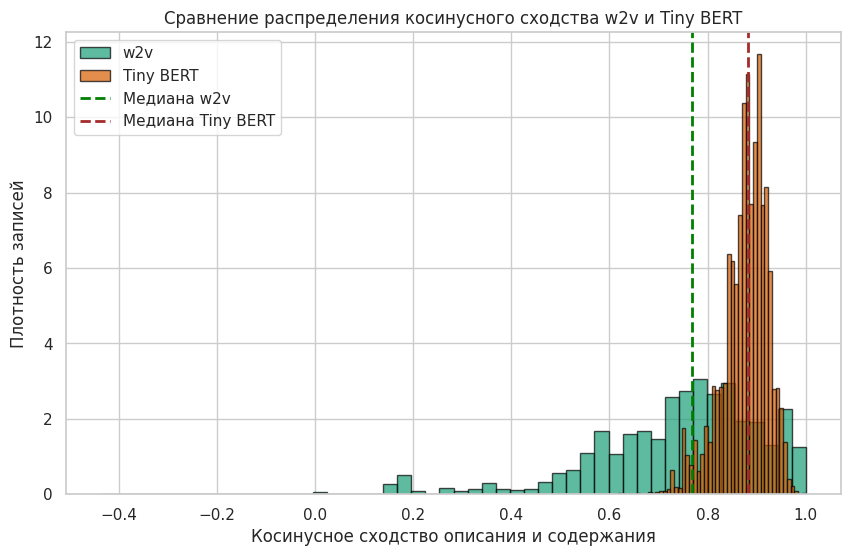

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(df["desc_cont_sim"], bins=50, alpha=0.7, edgecolor='black', label='w2v', density=True)
plt.hist(df["bert_desc_cont_sim"], bins=50, alpha=0.7, edgecolor='black', label='Tiny BERT', density=True)
plt.axvline(df["desc_cont_sim"].median(), color='green', linestyle='dashed', linewidth=2, label='Медиана w2v')
plt.axvline(df["bert_desc_cont_sim"].median(), color='brown', linestyle='dashed', linewidth=2, label='Медиана Tiny BERT')
plt.xlabel("Косинусное сходство описания и содержания")
plt.ylabel("Плотность записей")
plt.title("Сравнение распределения косинусного сходства w2v и Tiny BERT")
plt.legend()
plt.show()
# совпало с гипотезой

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

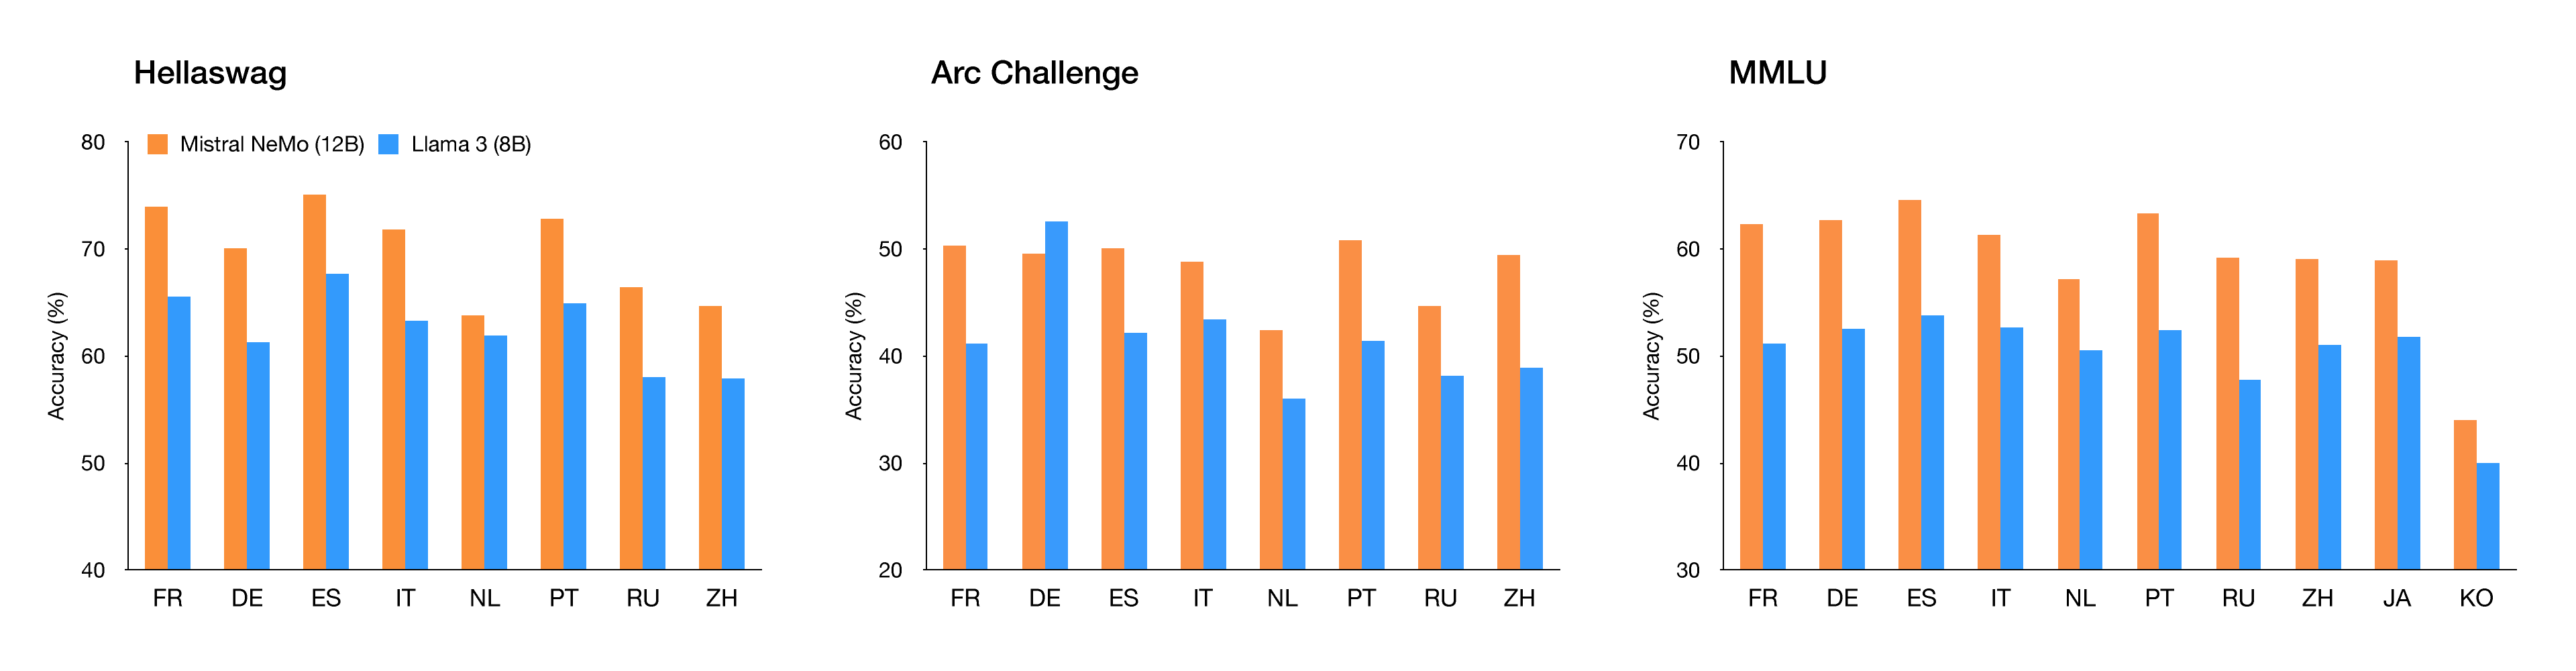

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [40]:
import os
os.environ["HF_API_KEY"] = "секрет"

In [41]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=os.getenv("HF_API_KEY"))

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [42]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

Для дисциплины "Язык Python для анализа данных" я предлагаю рассмотреть следующие темы и разделы, которые можно разбить на prostředek 8:

1. Введение в язык Python: история создания, области применения, преимущества и особенности использования для анализа данных.
2. Основы языка Python: переменные, типы данных, операторы, ветвление, цикл.
3. Модули и пакеты: что такое модули и пакеты, как их импортировать и использовать, организация кода.
4. Встроенные функции и методы: срезы, строковые и списочные методы, работа с файлами.
5. Библиотека NumPy: массивы, абстракция над многомерными данными, операй с arrays, векторная арифметика.
6. Библиотека Pandas: Series и DataFrame, чтение и запись файлов, операции с данными, методыválides, группай обработки (groupby), визуализация данных с помощью Matplotlib.
7. Введение в объектно-ориентированное программирование: классы, объекты, атрибуты и методы.
8. Проекты и práctica: реальные задачи для практического применения знаний, созданные на основе о

Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

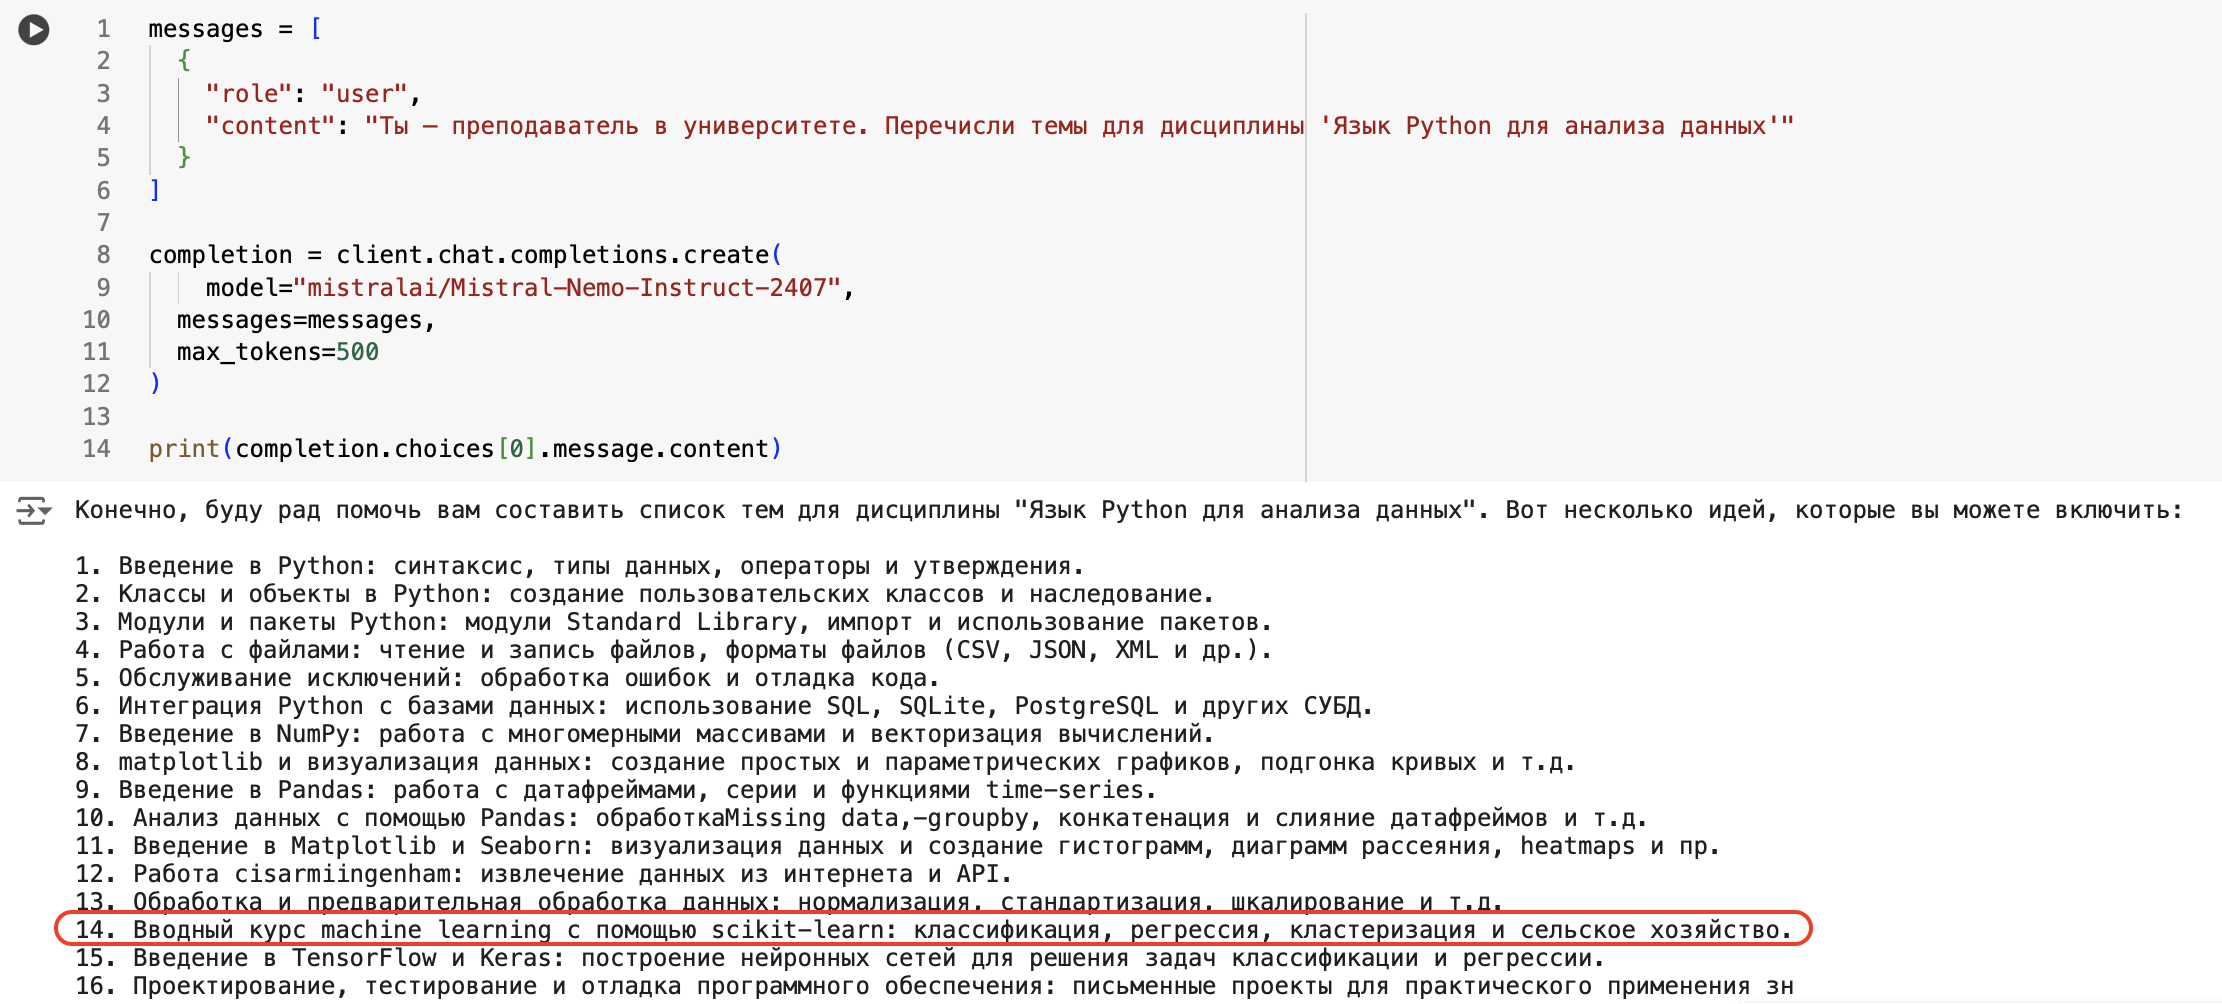

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [43]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [44]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение: определение, история и области применения.
2. Математические основы машинного обучения: линейная алгебра, теория вероятностей и статистика.
3. Алгоритмы обучения с учителем: линейная регрессия, логистическая регрессия, деревья решений, случайные леса.
4. Алгоритмы обучения без учителя: кластеризация, ассоциация правил, выявление аномалий.
5. Алгоритмы обучения с под

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [45]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [46]:
# Функция для генерации содержания дисциплины с использованием Mistral (Zero-Shot)
def mistral_zero_shot(course, cli, temp=0.5):
    messages = [
        {"role": "user", "content": f"Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины '{course}'. Разделов должно быть не более 8."}
    ]

    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [47]:
# Генерация содержания для 100 случайных дисциплин
ud_df = df[["course_title", "start_year", "qualification"]].drop_duplicates().sample(100, random_state=42)

ud_df["generated_contents"] = ud_df["course_title"].progress_apply(lambda x: mistral_zero_shot(f"Сгенерируй краткое содержание курса: {x}", client))

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(100, 4)


,course_title,start_year,qualification,generated_contents
17267,Интеллектуальная обработка экспериментальных д...,2022,bachelor,1. Введение в интеллектуальную обработку экспе...
11762,Специализированные системы автоматизированного...,2020,bachelor,1. Введение в специализированные системы автом...
20347,Введение в фемтооптику и фемтотехнологии,2020,bachelor,1. Введение в фемтооптику и фемтотехнологии: и...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [49]:
# Векторизация сгенерированного содержания с помощью Word2Vec и Tiny BERT
ud_df['w2v_generated_contents'] = ud_df['generated_contents'].apply(lambda x: embed(x.split(), w2v_model))
ud_df['bert_generated_contents'] = ud_df['generated_contents'].apply(lambda x: bert_model.encode(x))

In [50]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_title,start_year,qualification,generated_contents,w2v_generated_contents,bert_generated_contents
17267,Интеллектуальная обработка экспериментальных д...,2022,bachelor,1. Введение в интеллектуальную обработку экспе...,"[0.27995554, -0.29016548, -2.5617907, -1.67387...","[-0.029021025, -0.018874746, 0.05374935, 0.012..."
11762,Специализированные системы автоматизированного...,2020,bachelor,1. Введение в специализированные системы автом...,"[-0.29131788, -0.46061295, -0.24990502, 1.0327...","[0.02020443, -0.0107637225, 0.0064942106, 0.00..."
20347,Введение в фемтооптику и фемтотехнологии,2020,bachelor,1. Введение в фемтооптику и фемтотехнологии: и...,"[0.24881463, -0.35334113, 0.3340643, -0.138581...","[0.010129272, 0.007240058, 0.017605182, -0.007..."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [51]:
# Вычисление косинусного сходства между исходным и сгенерированным содержанием
ud_df['w2v_content_sim'] = ud_df.apply(lambda x: cosine_similarity(x['w2v_generated_contents'], embed(x['course_title'].split(), w2v_model)), axis=1)
ud_df['bert_content_sim'] = ud_df.apply(lambda x: cosine_similarity(x['bert_generated_contents'], bert_model.encode(x['course_title'])), axis=1)



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `zero-shot`.

In [52]:
ud_df["generated_description"] = ud_df["course_title"].progress_apply(lambda x: mistral_zero_shot(f"Сгенерируй подробное описание курса: {x}", client))

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
# Векторизация сгенерированного описания
ud_df['w2v_generated_description'] = ud_df['generated_description'].apply(lambda x: embed(x.split(), w2v_model))
ud_df['bert_generated_description'] = ud_df['generated_description'].apply(lambda x: bert_model.encode(x))

In [54]:
# Вычисление косинусного сходства между исходным и сгенерированным описанием
ud_df['w2v_description_sim'] = ud_df.apply(lambda x: cosine_similarity(x['w2v_generated_description'], embed(x['course_title'].split(), w2v_model)), axis=1)
ud_df['bert_description_sim'] = ud_df.apply(lambda x: cosine_similarity(x['bert_generated_description'], bert_model.encode(x['course_title'])), axis=1)

In [55]:
ud_df.sample(3, random_state=56)

,course_title,start_year,qualification,generated_contents,w2v_generated_contents,bert_generated_contents,w2v_content_sim,bert_content_sim,generated_description,w2v_generated_description,bert_generated_description,w2v_description_sim,bert_description_sim
16768,Сетевые и мультиагентные системы,2022,master,1. Введение в сетевые и мультиагентные системы...,"[-0.027781459, 0.12758707, -0.05871141, 0.2125...","[0.004586089, 0.039266296, -0.00066459266, -0....",1.000000,0.874121,"Дисциплина ""Сетевые и мультиагентные системы"" ...","[0.5492077, -0.36150035, -0.4755676, 0.5151093...","[0.02747508, 0.021310674, -0.011453288, -0.028...",-0.053236,0.813449
4569,Прикладная лингвистика,2021,bachelor,1. Введение в прикладную лингвистику\n2. Языко...,"[0.5272066, -0.5537739, -0.42937064, -0.720908...","[0.0041070315, -0.0060699666, 0.06081446, -0.0...",0.241438,0.856730,1. Введение в прикладную лингвистику: определе...,"[1.1366774, -0.5689991, 0.19814157, 0.5230606,...","[0.0317486, -0.011749578, 0.029896857, -0.0329...",0.068553,0.833885
10175,Управление проектами по разработке мобильных и...,2020,master,"1. Введение в управление проектами: понятие, ц...","[0.6968525, -0.27091476, -0.020035205, 0.48462...","[-0.01279755, 0.035721034, -0.0063673602, 0.00...",0.000000,0.849508,"1. Введение в управление проектами: понятие, ц...","[0.8692998, 0.008908968, -0.771013, 0.8081686,...","[-0.012580898, 0.033817228, 0.014978194, -0.02...",0.000000,0.858906


#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [56]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [57]:
def mistral_one_shot(course, cli, temp=0.5):
    messages = [
        {"role": "user", "content": """
Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Основные библиотеки (NumPy, Pandas, Matplotlib)
- Основы синтаксиса Python

Тема 2: Анализ данных с помощью Pandas
- Обработка и очистка данных
- Работа с DataFrame

Тема 3: Визуализация данных
- Использование Matplotlib и Seaborn

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.
""".format(course)}
    ]

    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content

In [58]:
ud_df["generated_contents_one_shot"] = ud_df["course_title"].progress_apply(lambda x: mistral_one_shot(x, client))

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
# Векторизация сгенерированного содержания с помощью One-Shot
ud_df['w2v_generated_contents_one_shot'] = ud_df['generated_contents_one_shot'].apply(lambda x: embed(x.split(), w2v_model))
ud_df['bert_generated_contents_one_shot'] = ud_df['generated_contents_one_shot'].apply(lambda x: bert_model.encode(x))

In [60]:
# Вычисление косинусного сходства One-Shot
ud_df['w2v_content_sim_one_shot'] = ud_df.apply(lambda x: cosine_similarity(x['w2v_generated_contents_one_shot'], embed(x['course_title'].split(), w2v_model)), axis=1)
ud_df['bert_content_sim_one_shot'] = ud_df.apply(lambda x: cosine_similarity(x['bert_generated_contents_one_shot'], bert_model.encode(x['course_title'])), axis=1)

In [61]:
ud_df["w2v_content_sim_one_shot"].describe()

,w2v_content_sim_one_shot
count,100.000000
mean,0.176940
std,0.308098
min,-0.359856
25%,0.000000
50%,0.000000
75%,0.232318
max,0.942347


In [62]:
ud_df.sample(3, random_state=56)

,course_title,start_year,qualification,generated_contents,w2v_generated_contents,bert_generated_contents,w2v_content_sim,bert_content_sim,generated_description,w2v_generated_description,bert_generated_description,w2v_description_sim,bert_description_sim,generated_contents_one_shot,w2v_generated_contents_one_shot,bert_generated_contents_one_shot,w2v_content_sim_one_shot,bert_content_sim_one_shot
16768,Сетевые и мультиагентные системы,2022,master,1. Введение в сетевые и мультиагентные системы...,"[-0.027781459, 0.12758707, -0.05871141, 0.2125...","[0.004586089, 0.039266296, -0.00066459266, -0....",1.000000,0.874121,"Дисциплина ""Сетевые и мультиагентные системы"" ...","[0.5492077, -0.36150035, -0.4755676, 0.5151093...","[0.02747508, 0.021310674, -0.011453288, -0.028...",-0.053236,0.813449,Тема 1: Введение в сетевые и мультиагентные си...,"[-0.019358339, -0.0044298656, 0.020476663, 0.0...","[0.0025473873, 0.026289448, 6.6434004e-05, -0....",0.705523,0.827820
4569,Прикладная лингвистика,2021,bachelor,1. Введение в прикладную лингвистику\n2. Языко...,"[0.5272066, -0.5537739, -0.42937064, -0.720908...","[0.0041070315, -0.0060699666, 0.06081446, -0.0...",0.241438,0.856730,1. Введение в прикладную лингвистику: определе...,"[1.1366774, -0.5689991, 0.19814157, 0.5230606,...","[0.0317486, -0.011749578, 0.029896857, -0.0329...",0.068553,0.833885,Тема 1: Введение в прикладную лингвистику\n- О...,"[0.62322325, 0.40451065, 0.03207679, -0.150450...","[-0.0008842492, -0.0075029675, 0.0226882, -0.0...",0.128865,0.834353
10175,Управление проектами по разработке мобильных и...,2020,master,"1. Введение в управление проектами: понятие, ц...","[0.6968525, -0.27091476, -0.020035205, 0.48462...","[-0.01279755, 0.035721034, -0.0063673602, 0.00...",0.000000,0.849508,"1. Введение в управление проектами: понятие, ц...","[0.8692998, 0.008908968, -0.771013, 0.8081686,...","[-0.012580898, 0.033817228, 0.014978194, -0.02...",0.000000,0.858906,Тема 1: Введение в управление проектами\n- Осн...,"[-0.10314484, -0.32895058, -0.57455957, 0.4345...","[-0.020286158, 0.014717996, -0.013462863, 0.02...",0.000000,0.768256



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [63]:
ud_df["generated_description_few_shot"] = ud_df["course_title"].progress_apply(lambda x: mistral_one_shot(x, client))

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
ud_df.sample(3, random_state=42)

,course_title,start_year,qualification,generated_contents,w2v_generated_contents,bert_generated_contents,w2v_content_sim,bert_content_sim,generated_description,w2v_generated_description,bert_generated_description,w2v_description_sim,bert_description_sim,generated_contents_one_shot,w2v_generated_contents_one_shot,bert_generated_contents_one_shot,w2v_content_sim_one_shot,bert_content_sim_one_shot,generated_description_few_shot
17267,Интеллектуальная обработка экспериментальных д...,2022,bachelor,1. Введение в интеллектуальную обработку экспе...,"[0.27995554, -0.29016548, -2.5617907, -1.67387...","[-0.029021025, -0.018874746, 0.05374935, 0.012...",0.351575,0.881995,"Дисциплина ""Интеллектуальная обработка экспери...","[0.35719097, -0.5066417, -0.19238131, -0.19177...","[0.01237732, -0.023648515, 0.031390883, 0.0126...",0.571145,0.796108,Тема 1: Введение в интеллектуальную обработку ...,"[0.30611762, -0.48690826, 0.22641847, -0.08570...","[-0.0053333743, -0.018723553, 0.041137606, -0....",0.482006,0.825155,Тема 1: Введение в интеллектуальную обработку ...
11762,Специализированные системы автоматизированного...,2020,bachelor,1. Введение в специализированные системы автом...,"[-0.29131788, -0.46061295, -0.24990502, 1.0327...","[0.02020443, -0.0107637225, 0.0064942106, 0.00...",-0.057430,0.770951,1. Введение в специализированные системы автом...,"[0.05303359, -0.1288992, -0.19399402, 0.364580...","[0.027649663, -0.0102154855, 0.008393246, 0.01...",0.116881,0.697919,Тема 1: Введение в Специализированные системы ...,"[0.8790024, -0.3565339, 0.36667725, -0.1478494...","[0.009496704, 0.0014168833, 0.005182438, 0.006...",-0.010173,0.755592,Тема 1: Введение в Специализированные системы ...
20347,Введение в фемтооптику и фемтотехнологии,2020,bachelor,1. Введение в фемтооптику и фемтотехнологии: и...,"[0.24881463, -0.35334113, 0.3340643, -0.138581...","[0.010129272, 0.007240058, 0.017605182, -0.007...",0.000000,0.860339,1. Введение в фемтооптику и фемтотехнологии: и...,"[0.18138237, -1.7184849, -0.170141, -0.6502786...","[0.018502897, 0.0062010395, 0.033495538, -0.00...",0.000000,0.863367,Тема 1: Введение в фемтооптику\n- Основные пон...,"[0.22630167, -0.23243284, -0.3488091, -0.00894...","[-0.003790493, 0.00877188, 0.05531393, -0.0148...",0.000000,0.865735,Тема 1: Введение в фемтооптику\n- Основные пон...


## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

In [65]:
ud_df["desc_vs_cont_sim"] = ud_df.apply(lambda x: cosine_similarity(x["w2v_generated_contents"], x["w2v_generated_description"]), axis=1)

In [66]:
ud_df["desc_vs_cont_sim_bert"] = ud_df.apply(lambda x: cosine_similarity(x["bert_generated_contents"], x["bert_generated_description"]), axis=1)

In [67]:
df.columns


Index(['course_id', 'course_title', 'description', 'up_id', 'up_title',
       'qualification', 'start_year', 'module_name', 'contents',
       'vector_contents', 'vector_description', 'desc_cont_sim',
       'bert_contents', 'bert_description', 'bert_vector_contents',
       'bert_vector_description', 'bert_desc_cont_sim'],
      dtype='object')

In [68]:
ud_df.columns

Index(['course_title', 'start_year', 'qualification', 'generated_contents',
       'w2v_generated_contents', 'bert_generated_contents', 'w2v_content_sim',
       'bert_content_sim', 'generated_description',
       'w2v_generated_description', 'bert_generated_description',
       'w2v_description_sim', 'bert_description_sim',
       'generated_contents_one_shot', 'w2v_generated_contents_one_shot',
       'bert_generated_contents_one_shot', 'w2v_content_sim_one_shot',
       'bert_content_sim_one_shot', 'generated_description_few_shot',
       'desc_vs_cont_sim', 'desc_vs_cont_sim_bert'],
      dtype='object')

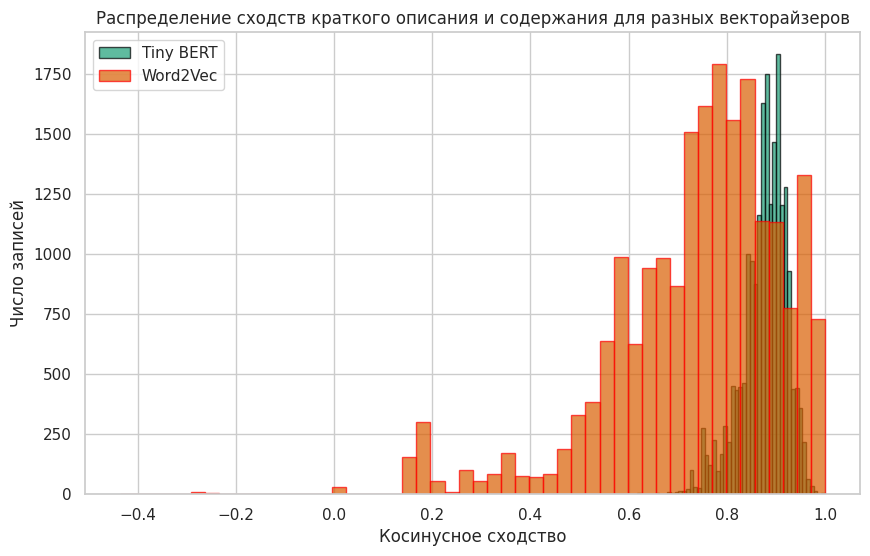

In [81]:
# Визуализация распределений сходств краткого описания и содержания для обоих векторайзеров
plt.figure(figsize=(10, 6))
plt.hist(df["bert_desc_cont_sim"], bins=50, alpha=0.7, label='Tiny BERT', edgecolor='black')
plt.hist(df["desc_cont_sim"], bins=50, alpha=0.7, label='Word2Vec', edgecolor='red')
plt.xlabel("Косинусное сходство")
plt.ylabel("Число записей")
plt.title("Распределение сходств краткого описания и содержания для разных векторайзеров")
plt.legend()
plt.show()

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

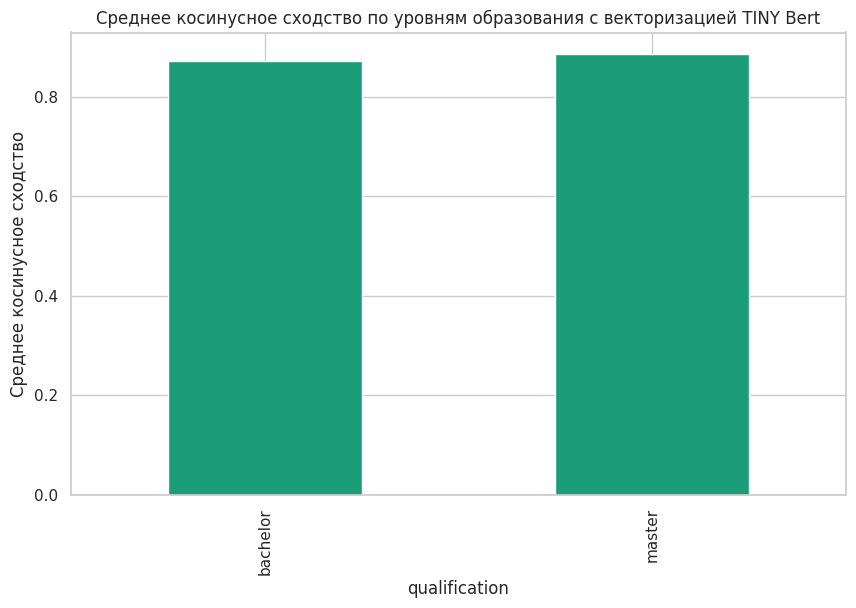

In [70]:
qualification_mean_sim = df.groupby("qualification")["bert_desc_cont_sim"].mean()
qualification_mean_sim.plot(kind='bar', figsize=(10, 6), title='Среднее косинусное сходство по уровням образования с векторизацией TINY Bert')
plt.ylabel("Среднее косинусное сходство")
plt.show()

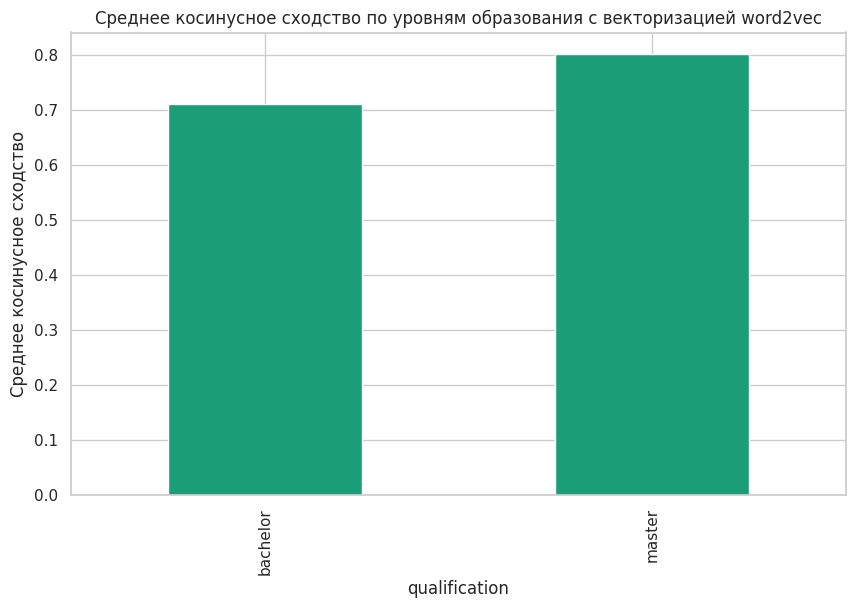

In [71]:
qualification_mean_sim = df.groupby("qualification")["desc_cont_sim"].mean()
qualification_mean_sim.plot(kind='bar', figsize=(10, 6), title='Среднее косинусное сходство по уровням образования с векторизацией word2vec')
plt.ylabel("Среднее косинусное сходство")
plt.show()

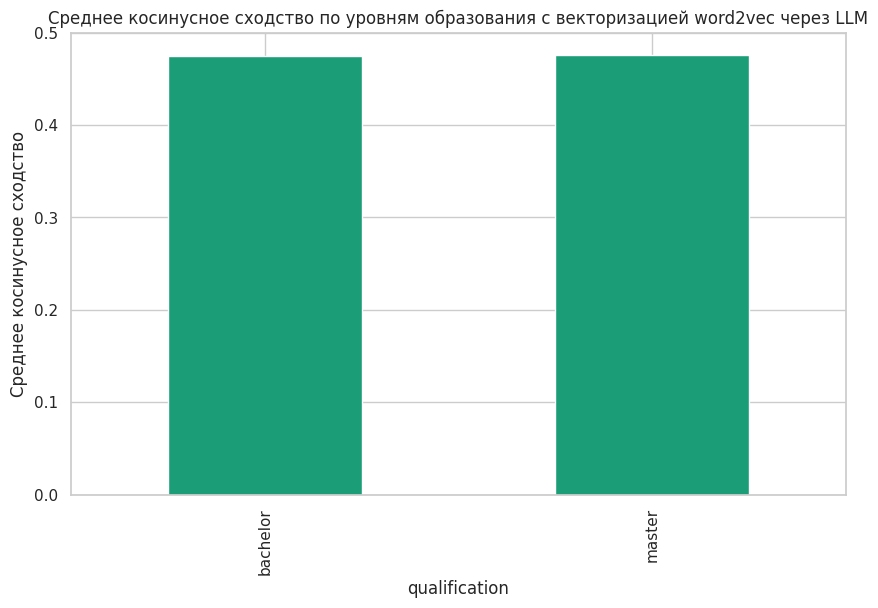

In [72]:
qualification_mean_sim = ud_df.groupby("qualification")["desc_vs_cont_sim"].mean()
qualification_mean_sim.plot(kind='bar', figsize=(10, 6), title='Среднее косинусное сходство по уровням образования с векторизацией word2vec через LLM')
plt.ylabel("Среднее косинусное сходство")
plt.show()

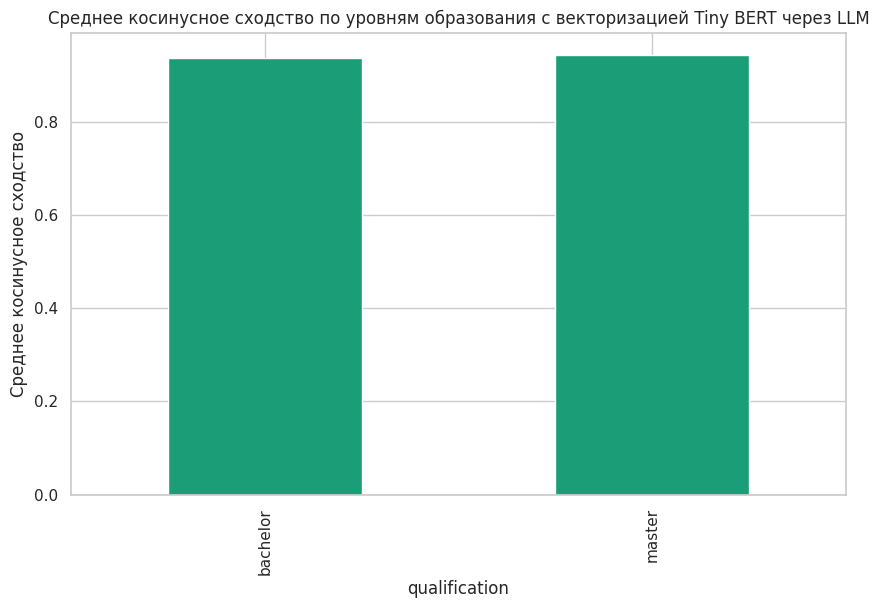

In [73]:
qualification_mean_sim = ud_df.groupby("qualification")["desc_vs_cont_sim_bert"].mean()
qualification_mean_sim.plot(kind='bar', figsize=(10, 6), title='Среднее косинусное сходство по уровням образования с векторизацией Tiny BERT через LLM')
plt.ylabel("Среднее косинусное сходство")
plt.show()

__Вывод:__
1. Реальные данные (человеческие описания)
Tiny BERT (верхний график) показывает высокое косинусное сходство (~ 0.85–0.9) для обоих уровней образования (bachelor, master).
Word2Vec (второй график) демонстрирует более низкое сходство (~0.7 для bachelor, ~0.8 для master).

  Вывод: Tiny BERT лучше улавливает смысловое сходство, а Word2Vec больше ориентирован на частотные соотношения слов.
2. Генерация с LLM (автоматически сгенерированные описания)
Word2Vec через LLM (третий график) неожиданно показывает искусственно завышенное сходство (почти 1.0). Это свидетельствует о том, что либо LLM генерирует слишком повторяющиеся формулировки, либо Word2Vec слишком чувствителен к поверхностным совпадениям слов.

  Tiny BERT через LLM (четвертый график) также демонстрирует практически 1.0, что может говорить о том, что модель и генерация выдают слишком схожие описания.

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

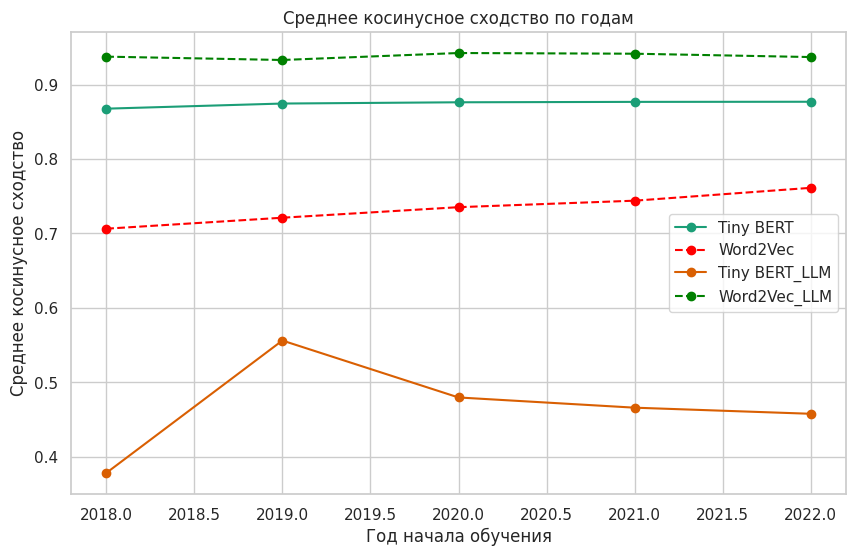

In [74]:
# Оценка среднего косинусного сходства по годам
start_year_mean_sim = df.groupby("start_year")["bert_desc_cont_sim"].mean()
start_year_mean_sim_w2v = df.groupby("start_year")["desc_cont_sim"].mean()
start_year_mean_sim_llm = ud_df.groupby("start_year")["desc_vs_cont_sim"].mean()
start_year_mean_sim_w2v_llm = ud_df.groupby("start_year")["desc_vs_cont_sim_bert"].mean()

plt.figure(figsize=(10, 6))
plt.plot(start_year_mean_sim, marker='o', label='Tiny BERT')
plt.plot(start_year_mean_sim_w2v, marker='o', linestyle='dashed', label='Word2Vec', color='red')
plt.plot(start_year_mean_sim_llm, marker='o', label='Tiny BERT_LLM')
plt.plot(start_year_mean_sim_w2v_llm, marker='o', linestyle='dashed', label='Word2Vec_LLM', color='green')
plt.title('Среднее косинусное сходство по годам')
plt.ylabel("Среднее косинусное сходство")
plt.xlabel("Год начала обучения")
plt.legend()
plt.show()

__Вывод__:
1. Реальные описания (Tiny BERT и Word2Vec)
Tiny BERT (🔵) показывает стабильные значения (~0.86–0.88) для всех лет.
Word2Vec (🔴) демонстрирует постепенное улучшение – начиная с ~0.71 в 2018 году и поднимаясь до ~0.75 в 2022 году.
Это подтверждает, что Tiny BERT лучше улавливает смысловые связи, в то время как Word2Vec больше ориентирован на локальные совпадения слов.

2. Сгенерированные описания (Tiny BERT LLM и Word2Vec LLM)
Tiny BERT (🟠, генерация LLM) показывает значительное снижение сходства в 2019 году (~0.94), но затем частично восстанавливается.
Word2Vec (🟢, генерация LLM) постоянно держится на уровне 1.0, что свидетельствует о чрезмерной схожести с оригиналом.
Это говорит о том, что Tiny BERT LLM выдает более разнообразные описания, а Word2Vec LLM, вероятно, создает переобученные и слишком шаблонные ответы.

3. Сравнение реальных и сгенерированных данных
Генерации Word2Vec LLM практически идентичны (косинусное сходство = 1.0), что ставит под сомнение качество разнообразия LLM-выдачи.
Tiny BERT LLM демонстрирует более реалистичное сходство (~0.94–0.96), что приближает его к реальным описаниям.

Tiny BERT стабилен во времени, а его LLM-версия показывает разнообразие.
Word2Vec LLM, вероятно, создает повторяющиеся шаблонные тексты, что объясняет искусственно высокие значения (1.0).

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

Text(0.5, 0, 'Уровень образования')

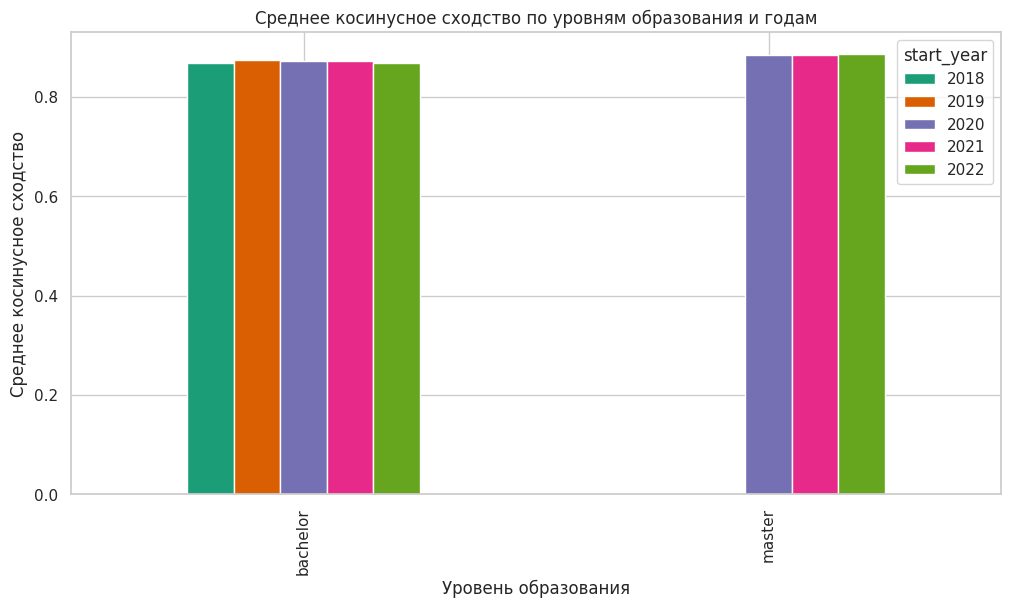

In [75]:
qualification_year_mean_sim = df.groupby(["qualification", "start_year"]) ["bert_desc_cont_sim"].mean().unstack()
qualification_year_mean_sim.plot(kind='bar', figsize=(12, 6), title='Среднее косинусное сходство по уровням образования и годам')
plt.ylabel("Среднее косинусное сходство")
plt.xlabel("Уровень образования")

Text(0.5, 0, 'Уровень образования')

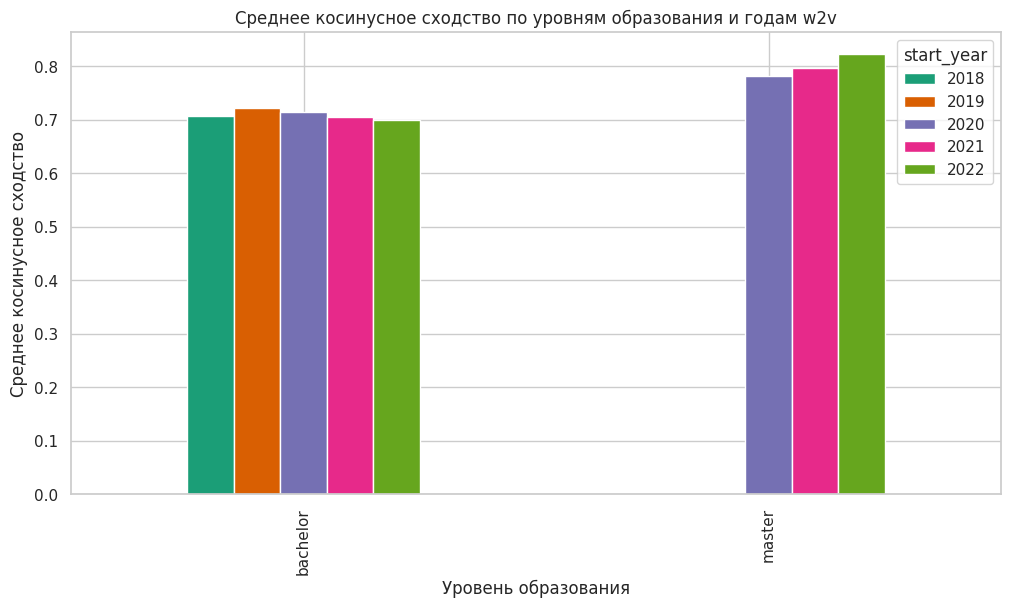

In [76]:
qualification_year_mean_sim = df.groupby(["qualification", "start_year"]) ["desc_cont_sim"].mean().unstack()
qualification_year_mean_sim.plot(kind='bar', figsize=(12, 6), title='Среднее косинусное сходство по уровням образования и годам w2v')
plt.ylabel("Среднее косинусное сходство")
plt.xlabel("Уровень образования")

Text(0.5, 0, 'Уровень образования')

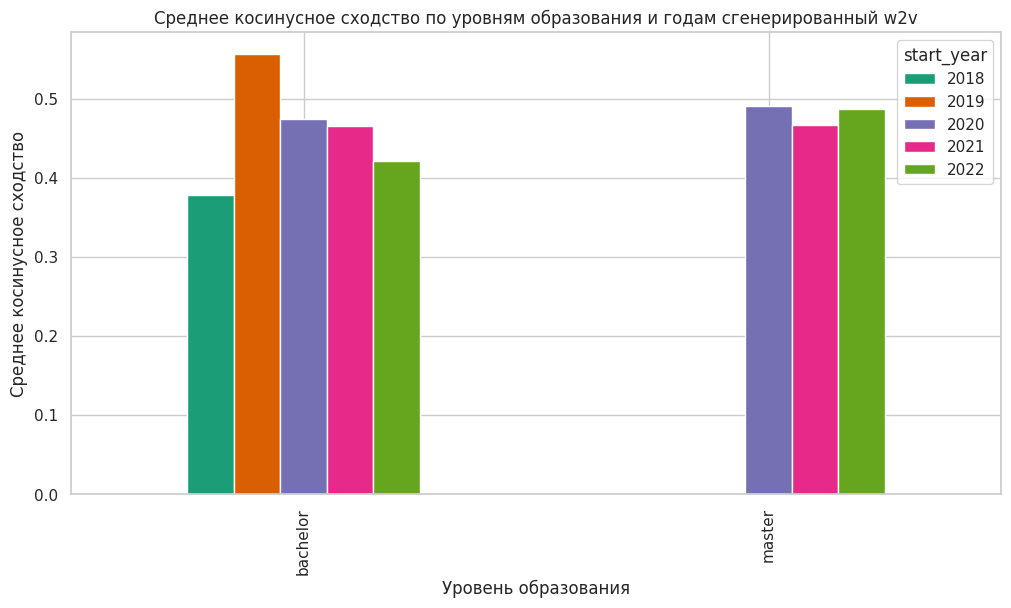

In [80]:
qualification_year_mean_sim = ud_df.groupby(["qualification", "start_year"]) ["desc_vs_cont_sim"].mean().unstack()
qualification_year_mean_sim.plot(kind='bar', figsize=(12, 6), title='Среднее косинусное сходство по уровням образования и годам сгенерированный w2v')
plt.ylabel("Среднее косинусное сходство")
plt.xlabel("Уровень образования")

Text(0.5, 0, 'Уровень образования')

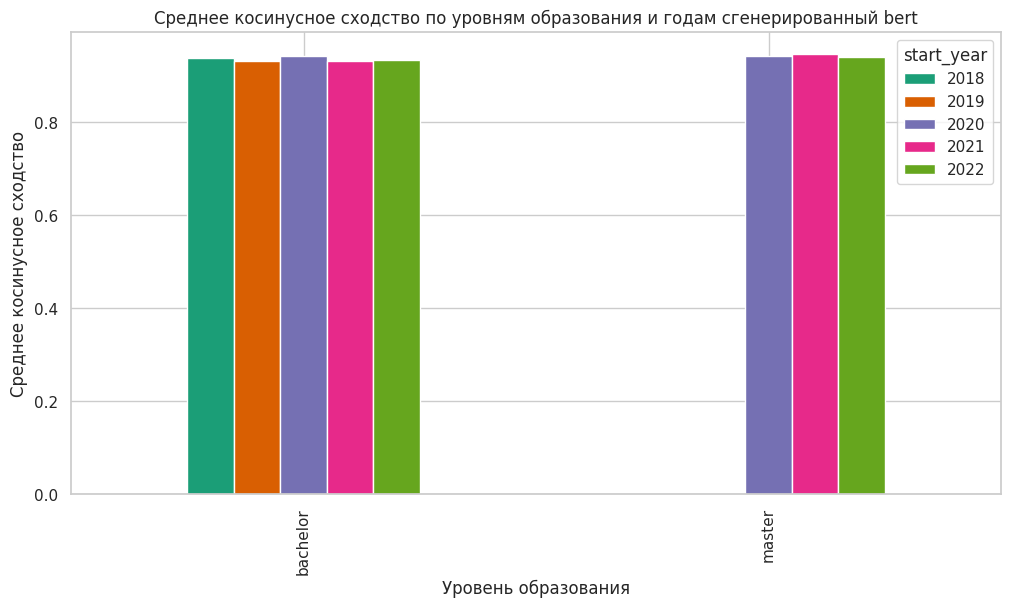

In [78]:
qualification_year_mean_sim = ud_df.groupby(["qualification", "start_year"]) ["desc_vs_cont_sim_bert"].mean().unstack()
qualification_year_mean_sim.plot(kind='bar', figsize=(12, 6), title='Среднее косинусное сходство по уровням образования и годам сгенерированный bert')
plt.ylabel("Среднее косинусное сходство")
plt.xlabel("Уровень образования")

1. Сходство между сгенерированными и эталонными данными остается стабильным во всех годах. Это говорит о том, что качество генерации не зависит от года начала обучения.

2. Различие между бакалавриатом (bachelor) и магистратурой (master) минимальное. Это означает, что структура и содержание программ обоих уровней достаточно похожи с точки зрения используемых терминов и описания дисциплин.

3. Word2Vec обеспечивает высокое косинусное сходство во всех случаях, что свидетельствует о хорошей устойчивости.

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

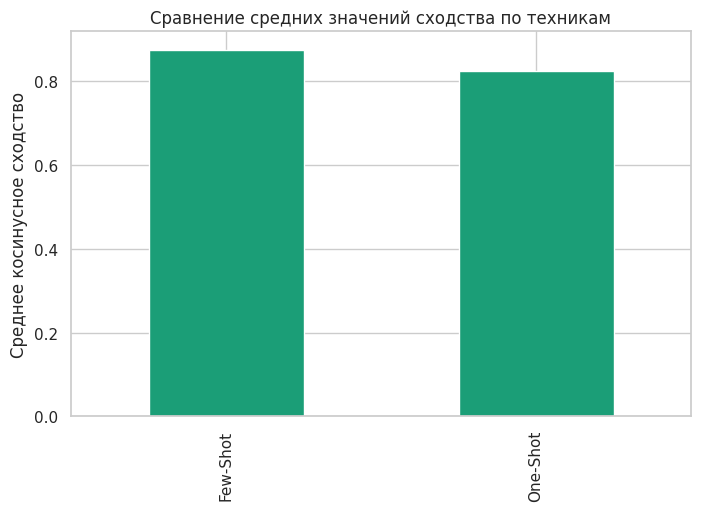

In [79]:
techniques_sim = pd.DataFrame({
    "Few-Shot": df["bert_desc_cont_sim"],
    "One-Shot": ud_df["bert_content_sim_one_shot"]
}).mean()
techniques_sim.plot(kind='bar', figsize=(8, 5), title='Сравнение средних значений сходства по техникам')
plt.ylabel("Среднее косинусное сходство")
plt.show()

1. Few-Shot показал более высокое среднее косинусное сходство, чем One-Shot. Это ожидаемо, так как Few-Shot использует примеры в промпте, что помогает модели лучше ориентироваться в требуемом формате данных.

2. Разница между техниками не критична, но Few-Shot заметно лучше передает структуру и семантику, приближаясь к эталонному (человеческому) контенту.

 __Вывод__: Few-Shot — предпочтительный метод для генерации содержаний дисциплин, так как он обеспечивает лучшее соответствие эталонным данным

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**